In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string

from scipy.spatial.distance import cosine

from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors

from tqdm import *

%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [7]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-ovr-linear-svc-calibrated/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS
SEED= 42

In [6]:
np.random.seed(SEED)

In [8]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [9]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [10]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [11]:
# # https://github.com/scikit-learn/scikit-learn/issues/6614
# class MyTfidfVectorizer(TfidfVectorizer):
#     def fit_transform(self, X, y):
#         result = super(MyTfidfVectorizer, self).fit_transform(X, y)
#         result.sort_indices()
#         return result

In [12]:
parameters = [
    { 
        "vect__max_features": [500,1000],
        "vect__norm": ['l1','l2',None],
        "nn__n_neighbors":[1,2,3,5,10,20,30,50,75,100],
        "nn__metric":["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]
    }
]

In [13]:
len(ParameterGrid(parameters))

360

In [14]:
for g in ParameterGrid(parameters):
    print(g)
    vect=TfidfVectorizer().set_params(**dict([(re.sub('^vect__','',k),v) for (k,v) in g.items() if k.startswith('vect__') ]))
    vect.fit(X_train)
    
    X_train_vect = vect.transform(X_train)
    X_val_vect = vect.transform(X_val)
    
    nbrs = NearestNeighbors().set_params(**dict([(re.sub('^nn__','',k),v) for (k,v) in g.items() if k.startswith('nn__') ]))
    nbrs.fit(X_train_vect)
    
    # just to make it easier to use it
    k = nbrs.n_neighbors
    
    # distance matrix shape: (num_validation_documents, k)
    # indices matrix shape: (num_validation_documents, k)
    distances_matrix_val, indices_matrix_val = nbrs.kneighbors(X_val_vect)
    
    # shape: (num_validation_documents, k, num_tags)
    neighbour_labels_tensor_val = Y_train[indices_matrix_val]
        
    Y_pred_val = []
        
    # for every validation document do
    for i in range(distances_matrix_val.shape[0]):
        # these are the labels from the neighbours of test document i
        # shape: (k, num_tags)
        neighbor_labels = neighbour_labels_tensor_val[i,:,:]
        
        # these are the distances from test document i to the nearest neighbours
        # shape: (k, )
        distances_to_neighbors = distances_matrix_val[i]
        
        # sum the contributions from all neighbors, for all tags
        # no need to normalize because we're only interested in the order
        y_preds = neighbor_labels.sum(axis=0)
                    
        Y_pred_val.append(y_preds)
               
    Y_pred_val = np.array(Y_pred_val)
    
    ks = [1,2,3,4,5,6,7,8,9,10]
    
    # k is the number of neighbors so let's use at_k
    for at_k in ks:
        print("validation micro-F1 @{}: {}".format(at_k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True))) 

    print('')    

{'nn__n_neighbors': 1, 'vect__max_features': 500, 'nn__metric': 'cityblock', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.12488350419384903
validation micro-F1 @2: 0.10991075622357914
validation micro-F1 @3: 0.09889763779527559
validation micro-F1 @4: 0.09379441023211749
validation micro-F1 @5: 0.09108159392789374
validation micro-F1 @6: 0.08563273073263558
validation micro-F1 @7: 0.08354878214723091
validation micro-F1 @8: 0.08061054137848796
validation micro-F1 @9: 0.07770700636942675
validation micro-F1 @10: 0.07464114832535886

{'nn__n_neighbors': 1, 'vect__max_features': 500, 'nn__metric': 'cityblock', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.11962616822429907
validation micro-F1 @2: 0.10099103350637093
validation micro-F1 @3: 0.09168510907366424
validation micro-F1 @4: 0.0838095238095238
validation micro-F1 @5: 0.0838095238095238
validation micro-F1 @6: 0.08045794243917952
validation micro-F1 @7: 0.07831900668576887
validation micro-F1 @8: 0.07487142686281545
validation mic

validation micro-F1 @4: 0.16297648938598494
validation micro-F1 @5: 0.151414920984932
validation micro-F1 @6: 0.14219759926131118
validation micro-F1 @7: 0.13629747254201402
validation micro-F1 @8: 0.13141397724634316
validation micro-F1 @9: 0.1281786231135001
validation micro-F1 @10: 0.12523294819232203

{'nn__n_neighbors': 3, 'vect__max_features': 1000, 'nn__metric': 'cityblock', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.18083182640144665
validation micro-F1 @2: 0.15835240274599544
validation micro-F1 @3: 0.14276923076923076
validation micro-F1 @4: 0.13876040703052728
validation micro-F1 @5: 0.13772676786375415
validation micro-F1 @6: 0.13300340241261985
validation micro-F1 @7: 0.12613092070250134
validation micro-F1 @8: 0.11962616822429907
validation micro-F1 @9: 0.11610486891385768
validation micro-F1 @10: 0.11133014174410964

{'nn__n_neighbors': 3, 'vect__max_features': 1000, 'nn__metric': 'cityblock', 'vect__norm': None}
validation micro-F1 @1: 0.14732965009208104
validation 

validation micro-F1 @10: 0.17074279479952723

{'nn__n_neighbors': 20, 'vect__max_features': 500, 'nn__metric': 'cityblock', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.2685025817555938
validation micro-F1 @2: 0.24356176342208644
validation micro-F1 @3: 0.22470588235294117
validation micro-F1 @4: 0.21076033792796797
validation micro-F1 @5: 0.1971326164874552
validation micro-F1 @6: 0.18793155208646053
validation micro-F1 @7: 0.1784790481117434
validation micro-F1 @8: 0.16903651461722216
validation micro-F1 @9: 0.1621841063635441
validation micro-F1 @10: 0.1581838154522153

{'nn__n_neighbors': 20, 'vect__max_features': 500, 'nn__metric': 'cityblock', 'vect__norm': None}
validation micro-F1 @1: 0.2534722222222222
validation micro-F1 @2: 0.21868083222664897
validation micro-F1 @3: 0.20196604110813227
validation micro-F1 @4: 0.1861618210502592
validation micro-F1 @5: 0.17190623296383792
validation micro-F1 @6: 0.16924476797088261
validation micro-F1 @7: 0.16207751533342032
validation micr

validation micro-F1 @4: 0.23894967177242887
validation micro-F1 @5: 0.22606242285311232
validation micro-F1 @6: 0.2118204710413272
validation micro-F1 @7: 0.2065452693238253
validation micro-F1 @8: 0.19834340720841728
validation micro-F1 @9: 0.19010494752623688
validation micro-F1 @10: 0.18231095853283946

{'nn__n_neighbors': 50, 'vect__max_features': 1000, 'nn__metric': 'cityblock', 'vect__norm': None}
validation micro-F1 @1: 0.2773972602739726
validation micro-F1 @2: 0.2443280977312391
validation micro-F1 @3: 0.22627093740816925
validation micro-F1 @4: 0.2155210643015521
validation micro-F1 @5: 0.20709320976653003
validation micro-F1 @6: 0.19793999104343932
validation micro-F1 @7: 0.19389587073608616
validation micro-F1 @8: 0.18411552346570398
validation micro-F1 @9: 0.17771963369226124
validation micro-F1 @10: 0.1709090909090909

{'nn__n_neighbors': 75, 'vect__max_features': 500, 'nn__metric': 'cityblock', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.2685025817555938
validation mic

validation micro-F1 @7: 0.06803840877914952
validation micro-F1 @8: 0.06608194160759341
validation micro-F1 @9: 0.06393670480059874
validation micro-F1 @10: 0.06128348429369821

{'nn__n_neighbors': 1, 'vect__max_features': 500, 'nn__metric': 'cosine', 'vect__norm': None}
validation micro-F1 @1: 0.08563273073263558
validation micro-F1 @2: 0.08289661743687471
validation micro-F1 @3: 0.07218141168955605
validation micro-F1 @4: 0.07187350263536177
validation micro-F1 @5: 0.07057920981971615
validation micro-F1 @6: 0.06755242516407876
validation micro-F1 @7: 0.06803840877914952
validation micro-F1 @8: 0.06608194160759341
validation micro-F1 @9: 0.06393670480059874
validation micro-F1 @10: 0.06128348429369821

{'nn__n_neighbors': 1, 'vect__max_features': 1000, 'nn__metric': 'cosine', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.1107981220657277
validation micro-F1 @2: 0.10009442870632672
validation micro-F1 @3: 0.0892687559354226
validation micro-F1 @4: 0.08745247148288973
validation micro-

validation micro-F1 @1: 0.19389587073608616
validation micro-F1 @2: 0.16924476797088261
validation micro-F1 @3: 0.15412844036697249
validation micro-F1 @4: 0.14048059149722736
validation micro-F1 @5: 0.1283720930232558
validation micro-F1 @6: 0.12225851609892674
validation micro-F1 @7: 0.11408677021960364
validation micro-F1 @8: 0.1092446846000235
validation micro-F1 @9: 0.1044698000628075
validation micro-F1 @10: 0.1018867924528302

{'nn__n_neighbors': 5, 'vect__max_features': 500, 'nn__metric': 'cosine', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.18901890189018902
validation micro-F1 @2: 0.17339990921470722
validation micro-F1 @3: 0.1586333129957291
validation micro-F1 @4: 0.14262635587352873
validation micro-F1 @5: 0.13427299703264095
validation micro-F1 @6: 0.12779156327543426
validation micro-F1 @7: 0.12338441039307128
validation micro-F1 @8: 0.1187470780738663
validation micro-F1 @9: 0.11669266770670828
validation micro-F1 @10: 0.1125703564727955

{'nn__n_neighbors': 5, 'vect_

validation micro-F1 @7: 0.16876869067741515
validation micro-F1 @8: 0.15961582437685798
validation micro-F1 @9: 0.1560081466395112
validation micro-F1 @10: 0.15090524767944122

{'nn__n_neighbors': 20, 'vect__max_features': 1000, 'nn__metric': 'cosine', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.24585876198779424
validation micro-F1 @2: 0.22339955849889626
validation micro-F1 @3: 0.20517395182872436
validation micro-F1 @4: 0.19389587073608616
validation micro-F1 @5: 0.18771392541884346
validation micro-F1 @6: 0.1783612494341331
validation micro-F1 @7: 0.1744653272845107
validation micro-F1 @8: 0.17028532454245765
validation micro-F1 @9: 0.16292989753474688
validation micro-F1 @10: 0.1581838154522153

{'nn__n_neighbors': 20, 'vect__max_features': 1000, 'nn__metric': 'cosine', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.24585876198779424
validation micro-F1 @2: 0.22339955849889626
validation micro-F1 @3: 0.20517395182872436
validation micro-F1 @4: 0.19389587073608616
validation micro

validation micro-F1 @1: 0.23198594024604569
validation micro-F1 @2: 0.2099644128113879
validation micro-F1 @3: 0.19982105577095138
validation micro-F1 @4: 0.1906474820143885
validation micro-F1 @5: 0.1834597327555074
validation micro-F1 @6: 0.17781132075471698
validation micro-F1 @7: 0.1737551867219917
validation micro-F1 @8: 0.16945297395655634
validation micro-F1 @9: 0.16441966548403447
validation micro-F1 @10: 0.1596999908533797

{'nn__n_neighbors': 75, 'vect__max_features': 500, 'nn__metric': 'cosine', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.23198594024604569
validation micro-F1 @2: 0.2099644128113879
validation micro-F1 @3: 0.19982105577095138
validation micro-F1 @4: 0.1906474820143885
validation micro-F1 @5: 0.1834597327555074
validation micro-F1 @6: 0.17781132075471698
validation micro-F1 @7: 0.1737551867219917
validation micro-F1 @8: 0.16945297395655634
validation micro-F1 @9: 0.16441966548403447
validation micro-F1 @10: 0.1596999908533797

{'nn__n_neighbors': 75, 'vect__

validation micro-F1 @7: 0.07543044547690626
validation micro-F1 @8: 0.07302765473482581
validation micro-F1 @9: 0.07053809270111881
validation micro-F1 @10: 0.06631427198462278

{'nn__n_neighbors': 1, 'vect__max_features': 1000, 'nn__metric': 'euclidean', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.1107981220657277
validation micro-F1 @2: 0.10009442870632672
validation micro-F1 @3: 0.0892687559354226
validation micro-F1 @4: 0.08745247148288973
validation micro-F1 @5: 0.0852683669585078
validation micro-F1 @6: 0.08289661743687471
validation micro-F1 @7: 0.08015267175572519
validation micro-F1 @8: 0.07671167403512964
validation micro-F1 @9: 0.07545966627696886
validation micro-F1 @10: 0.07168870998658233

{'nn__n_neighbors': 1, 'vect__max_features': 1000, 'nn__metric': 'euclidean', 'vect__norm': None}
validation micro-F1 @1: 0.0946969696969697
validation micro-F1 @2: 0.07831900668576887
validation micro-F1 @3: 0.07954183900731784
validation micro-F1 @4: 0.07371948300622308
validation m

validation micro-F1 @10: 0.10831139526137645

{'nn__n_neighbors': 5, 'vect__max_features': 500, 'nn__metric': 'euclidean', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.18901890189018902
validation micro-F1 @2: 0.17339990921470722
validation micro-F1 @3: 0.1586333129957291
validation micro-F1 @4: 0.14262635587352873
validation micro-F1 @5: 0.13427299703264095
validation micro-F1 @6: 0.12779156327543426
validation micro-F1 @7: 0.12338441039307128
validation micro-F1 @8: 0.1187470780738663
validation micro-F1 @9: 0.11669266770670828
validation micro-F1 @10: 0.1125703564727955

{'nn__n_neighbors': 5, 'vect__max_features': 500, 'nn__metric': 'euclidean', 'vect__norm': None}
validation micro-F1 @1: 0.16924476797088261
validation micro-F1 @2: 0.15328132170720515
validation micro-F1 @3: 0.14846625766871166
validation micro-F1 @4: 0.13444598980064906
validation micro-F1 @5: 0.1276754141075749
validation micro-F1 @6: 0.12225851609892674
validation micro-F1 @7: 0.11332886805090422
validation mic

validation micro-F1 @1: 0.24585876198779424
validation micro-F1 @2: 0.22339955849889626
validation micro-F1 @3: 0.20517395182872436
validation micro-F1 @4: 0.19389587073608616
validation micro-F1 @5: 0.18771392541884346
validation micro-F1 @6: 0.1783612494341331
validation micro-F1 @7: 0.1744653272845107
validation micro-F1 @8: 0.17028532454245765
validation micro-F1 @9: 0.16292989753474688
validation micro-F1 @10: 0.1581838154522153

{'nn__n_neighbors': 20, 'vect__max_features': 1000, 'nn__metric': 'euclidean', 'vect__norm': None}
validation micro-F1 @1: 0.2534722222222222
validation micro-F1 @2: 0.22965244170699517
validation micro-F1 @3: 0.21155555555555555
validation micro-F1 @4: 0.20236765691311145
validation micro-F1 @5: 0.18673395818312905
validation micro-F1 @6: 0.18083182640144665
validation micro-F1 @7: 0.17257039055404177
validation micro-F1 @8: 0.1671601002049647
validation micro-F1 @9: 0.16199756394640683
validation micro-F1 @10: 0.15649624335715595

{'nn__n_neighbors': 30

validation micro-F1 @6: 0.17781132075471698
validation micro-F1 @7: 0.1737551867219917
validation micro-F1 @8: 0.16945297395655634
validation micro-F1 @9: 0.16441966548403447
validation micro-F1 @10: 0.1596999908533797

{'nn__n_neighbors': 75, 'vect__max_features': 500, 'nn__metric': 'euclidean', 'vect__norm': None}
validation micro-F1 @1: 0.2905692438402719
validation micro-F1 @2: 0.2534722222222222
validation micro-F1 @3: 0.23302107728337237
validation micro-F1 @4: 0.21868083222664897
validation micro-F1 @5: 0.20517395182872436
validation micro-F1 @6: 0.19767094655120931
validation micro-F1 @7: 0.18901890189018902
validation micro-F1 @8: 0.18411552346570398
validation micro-F1 @9: 0.17881926983807703
validation micro-F1 @10: 0.17604931556522527

{'nn__n_neighbors': 75, 'vect__max_features': 1000, 'nn__metric': 'euclidean', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.2427947598253275
validation micro-F1 @2: 0.2155210643015521
validation micro-F1 @3: 0.20303661804108367
validation mi

validation micro-F1 @10: 0.06965365058044709

{'nn__n_neighbors': 1, 'vect__max_features': 1000, 'nn__metric': 'l1', 'vect__norm': None}
validation micro-F1 @1: 0.12138188608776844
validation micro-F1 @2: 0.10009442870632672
validation micro-F1 @3: 0.08745247148288973
validation micro-F1 @4: 0.08061054137848796
validation micro-F1 @5: 0.07978621874403512
validation micro-F1 @6: 0.07709461611978337
validation micro-F1 @7: 0.07411459045535349
validation micro-F1 @8: 0.07118034751348112
validation micro-F1 @9: 0.06806785447562147
validation micro-F1 @10: 0.06519857678622945

{'nn__n_neighbors': 2, 'vect__max_features': 500, 'nn__metric': 'l1', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.12488350419384903
validation micro-F1 @2: 0.13184772516248838
validation micro-F1 @3: 0.11962616822429907
validation micro-F1 @4: 0.11786716557530402
validation micro-F1 @5: 0.11327831957989497
validation micro-F1 @6: 0.10842995926041993
validation micro-F1 @7: 0.10495156081808396
validation micro-F1 @8:

validation micro-F1 @4: 0.13789912077741787
validation micro-F1 @5: 0.12906825367305189
validation micro-F1 @6: 0.12138188608776844
validation micro-F1 @7: 0.12037902041905779
validation micro-F1 @8: 0.11588434976003746
validation micro-F1 @9: 0.11237360575419576
validation micro-F1 @10: 0.10884481624212802

{'nn__n_neighbors': 5, 'vect__max_features': 1000, 'nn__metric': 'l1', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.2534722222222222
validation micro-F1 @2: 0.2123500666370502
validation micro-F1 @3: 0.19767094655120931
validation micro-F1 @4: 0.1837057097720605
validation micro-F1 @5: 0.17290228841264074
validation micro-F1 @6: 0.16785551677037486
validation micro-F1 @7: 0.15919487648673375
validation micro-F1 @8: 0.15349317425719858
validation micro-F1 @9: 0.14903403863845446
validation micro-F1 @10: 0.14476717381281698

{'nn__n_neighbors': 5, 'vect__max_features': 1000, 'nn__metric': 'l1', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.2003577817531306
validation micro-F1 @2: 0.

validation micro-F1 @10: 0.15666513971598717

{'nn__n_neighbors': 30, 'vect__max_features': 500, 'nn__metric': 'l1', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.2876595744680851
validation micro-F1 @2: 0.23972003499562555
validation micro-F1 @3: 0.2293927838075682
validation micro-F1 @4: 0.21472937000887313
validation micro-F1 @5: 0.20421278114958943
validation micro-F1 @6: 0.1957853833507697
validation micro-F1 @7: 0.18901890189018902
validation micro-F1 @8: 0.18513924906979368
validation micro-F1 @9: 0.17973462002412546
validation micro-F1 @10: 0.17588395285584768

{'nn__n_neighbors': 30, 'vect__max_features': 500, 'nn__metric': 'l1', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.2891156462585034
validation micro-F1 @2: 0.24738675958188153
validation micro-F1 @3: 0.22991202346041056
validation micro-F1 @4: 0.21274705751721074
validation micro-F1 @5: 0.1968094640616598
validation micro-F1 @6: 0.18575293056807934
validation micro-F1 @7: 0.17989144481778238
validation micro-F1 @8: 0.1

validation micro-F1 @4: 0.25119513255106474
validation micro-F1 @5: 0.23384831460674158
validation micro-F1 @6: 0.2252278741546604
validation micro-F1 @7: 0.21766641356618577
validation micro-F1 @8: 0.2099644128113879
validation micro-F1 @9: 0.20410592085688783
validation micro-F1 @10: 0.19858537022114783

{'nn__n_neighbors': 75, 'vect__max_features': 1000, 'nn__metric': 'l1', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.33167495854063017
validation micro-F1 @2: 0.29346904156064463
validation micro-F1 @3: 0.2665134979896611
validation micro-F1 @4: 0.2470050098017861
validation micro-F1 @5: 0.23384831460674158
validation micro-F1 @6: 0.21710234824988922
validation micro-F1 @7: 0.2076864342071774
validation micro-F1 @8: 0.20156424581005586
validation micro-F1 @9: 0.19353551476456504
validation micro-F1 @10: 0.18836664865838285

{'nn__n_neighbors': 75, 'vect__max_features': 1000, 'nn__metric': 'l1', 'vect__norm': None}
validation micro-F1 @1: 0.28620102214650767
validation micro-F1 @2: 0

validation micro-F1 @10: 0.08344446561249762

{'nn__n_neighbors': 2, 'vect__max_features': 500, 'nn__metric': 'l2', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.13876040703052728
validation micro-F1 @2: 0.12050443717888837
validation micro-F1 @3: 0.10902255639097744
validation micro-F1 @4: 0.10233435510492808
validation micro-F1 @5: 0.09793911892607299
validation micro-F1 @6: 0.09649952696310313
validation micro-F1 @7: 0.09418132611637348
validation micro-F1 @8: 0.09130795683623859
validation micro-F1 @9: 0.08947035239502005
validation micro-F1 @10: 0.08727065310390722

{'nn__n_neighbors': 2, 'vect__max_features': 500, 'nn__metric': 'l2', 'vect__norm': None}
validation micro-F1 @1: 0.11433926897844424
validation micro-F1 @2: 0.10546139359698682
validation micro-F1 @3: 0.09289099526066351
validation micro-F1 @4: 0.09062870699881376
validation micro-F1 @5: 0.08817939946788293
validation micro-F1 @6: 0.08563273073263558
validation micro-F1 @7: 0.08146029151341778
validation micro-F1 @8: 

validation micro-F1 @4: 0.15497478220999542
validation micro-F1 @5: 0.14254062038404727
validation micro-F1 @6: 0.13588634959851761
validation micro-F1 @7: 0.13011152416356878
validation micro-F1 @8: 0.12510192195690156
validation micro-F1 @9: 0.12060197197716659
validation micro-F1 @10: 0.11557553619930692

{'nn__n_neighbors': 5, 'vect__max_features': 1000, 'nn__metric': 'l2', 'vect__norm': None}
validation micro-F1 @1: 0.17257039055404177
validation micro-F1 @2: 0.14476717381281698
validation micro-F1 @3: 0.13415765069551777
validation micro-F1 @4: 0.1283720930232558
validation micro-F1 @5: 0.12243374393430384
validation micro-F1 @6: 0.11728009981285091
validation micro-F1 @7: 0.11307609860664523
validation micro-F1 @8: 0.11035454332002817
validation micro-F1 @9: 0.10763925175044414
validation micro-F1 @10: 0.10563977026645326

{'nn__n_neighbors': 10, 'vect__max_features': 500, 'nn__metric': 'l2', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2:

validation micro-F1 @10: 0.15514395745461215

{'nn__n_neighbors': 30, 'vect__max_features': 500, 'nn__metric': 'l2', 'vect__norm': None}
validation micro-F1 @1: 0.2564991334488735
validation micro-F1 @2: 0.2312087912087912
validation micro-F1 @3: 0.21736562315416422
validation micro-F1 @4: 0.200760116253074
validation micro-F1 @5: 0.18901890189018902
validation micro-F1 @6: 0.17863608931804467
validation micro-F1 @7: 0.1739919616232335
validation micro-F1 @8: 0.16945297395655634
validation micro-F1 @9: 0.16702095353780747
validation micro-F1 @10: 0.16356334428623584

{'nn__n_neighbors': 30, 'vect__max_features': 1000, 'nn__metric': 'l2', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.2427947598253275
validation micro-F1 @2: 0.21946902654867256
validation micro-F1 @3: 0.2003577817531306
validation micro-F1 @4: 0.19349046015712681
validation micro-F1 @5: 0.18116073042849395
validation micro-F1 @6: 0.1772610599426242
validation micro-F1 @7: 0.1716214461897962
validation micro-F1 @8: 0.1663

validation micro-F1 @4: 0.223791657470757
validation micro-F1 @5: 0.21757618710134657
validation micro-F1 @6: 0.20650720546724113
validation micro-F1 @7: 0.19851624456382708
validation micro-F1 @8: 0.1906474820143885
validation micro-F1 @9: 0.18484362469927826
validation micro-F1 @10: 0.17918552036199095

{'nn__n_neighbors': 100, 'vect__max_features': 500, 'nn__metric': 'l2', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.22887323943661972
validation micro-F1 @2: 0.21472937000887313
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.18901890189018902
validation micro-F1 @5: 0.18280346820809248
validation micro-F1 @6: 0.17973462002412546
validation micro-F1 @7: 0.17209604153147307
validation micro-F1 @8: 0.16986924388857305
validation micro-F1 @9: 0.16757741347905283
validation micro-F1 @10: 0.16607419560659922

{'nn__n_neighbors': 100, 'vect__max_features': 500, 'nn__metric': 'l2', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.22104332449160036
validation micro-F1 @2: 

validation micro-F1 @10: 0.08763425529892596

{'nn__n_neighbors': 2, 'vect__max_features': 1000, 'nn__metric': 'manhattan', 'vect__norm': 'l1'}
validation micro-F1 @1: 0.1906474820143885
validation micro-F1 @2: 0.17753623188405798
validation micro-F1 @3: 0.1569465648854962
validation micro-F1 @4: 0.15200918484500575
validation micro-F1 @5: 0.14322628276116647
validation micro-F1 @6: 0.13242574257425743
validation micro-F1 @7: 0.12911795961742828
validation micro-F1 @8: 0.12532028884230142
validation micro-F1 @9: 0.12293977402301233
validation micro-F1 @10: 0.11786716557530402

{'nn__n_neighbors': 2, 'vect__max_features': 1000, 'nn__metric': 'manhattan', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.1709090909090909
validation micro-F1 @2: 0.15328132170720515
validation micro-F1 @3: 0.13933415536374846
validation micro-F1 @4: 0.13098002786809104
validation micro-F1 @5: 0.12558226197130612
validation micro-F1 @6: 0.1169864295741694
validation micro-F1 @7: 0.11358156978301634
validation m

validation micro-F1 @1: 0.26252158894645944
validation micro-F1 @2: 0.2280933509467195
validation micro-F1 @3: 0.20196604110813227
validation micro-F1 @4: 0.19024061164830222
validation micro-F1 @5: 0.17852616331703783
validation micro-F1 @6: 0.16785551677037486
validation micro-F1 @7: 0.16159770264978462
validation micro-F1 @8: 0.15539766215906486
validation micro-F1 @9: 0.15111292628139678
validation micro-F1 @10: 0.1461347092969686

{'nn__n_neighbors': 10, 'vect__max_features': 500, 'nn__metric': 'manhattan', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.2257495590828924
validation micro-F1 @2: 0.21631205673758866
validation micro-F1 @3: 0.19982105577095138
validation micro-F1 @4: 0.18165386353366472
validation micro-F1 @5: 0.16757741347905283
validation micro-F1 @6: 0.1600365797896662
validation micro-F1 @7: 0.15606179628174915
validation micro-F1 @8: 0.15116011945784516
validation micro-F1 @9: 0.146381410584502
validation micro-F1 @10: 0.14133949191685913

{'nn__n_neighbors': 10, 

validation micro-F1 @7: 0.2076864342071774
validation micro-F1 @8: 0.20116227089852481
validation micro-F1 @9: 0.19551569506726457
validation micro-F1 @10: 0.18934485241180707

{'nn__n_neighbors': 30, 'vect__max_features': 1000, 'nn__metric': 'manhattan', 'vect__norm': 'l2'}
validation micro-F1 @1: 0.30210970464135023
validation micro-F1 @2: 0.2496737712048717
validation micro-F1 @3: 0.24074613815214224
validation micro-F1 @4: 0.2284833810257539
validation micro-F1 @5: 0.2150461320085167
validation micro-F1 @6: 0.2059741417744093
validation micro-F1 @7: 0.2003577817531306
validation micro-F1 @8: 0.1896299628838151
validation micro-F1 @9: 0.1810145655449523
validation micro-F1 @10: 0.17439433808184376

{'nn__n_neighbors': 30, 'vect__max_features': 1000, 'nn__metric': 'manhattan', 'vect__norm': None}
validation micro-F1 @1: 0.2905692438402719
validation micro-F1 @2: 0.23740692071835304
validation micro-F1 @3: 0.22313806299676184
validation micro-F1 @4: 0.20717308977500556
validation micr

validation micro-F1 @1: 0.2832764505119454
validation micro-F1 @2: 0.24125874125874125
validation micro-F1 @3: 0.22679200940070504
validation micro-F1 @4: 0.2155210643015521
validation micro-F1 @5: 0.20389216211390823
validation micro-F1 @6: 0.20008945877441478
validation micro-F1 @7: 0.19134454860665212
validation micro-F1 @8: 0.18432036097010715
validation micro-F1 @9: 0.17863608931804467
validation micro-F1 @10: 0.17406298212178964

{'nn__n_neighbors': 100, 'vect__max_features': 500, 'nn__metric': 'manhattan', 'vect__norm': None}
validation micro-F1 @1: 0.31066330814441645
validation micro-F1 @2: 0.26026805015131865
validation micro-F1 @3: 0.23611922852133255
validation micro-F1 @4: 0.22065001105460977
validation micro-F1 @5: 0.2112375533428165
validation micro-F1 @6: 0.20062602474288269
validation micro-F1 @7: 0.19087989723827875
validation micro-F1 @8: 0.18534385569334835
validation micro-F1 @9: 0.17753623188405798
validation micro-F1 @10: 0.17306819213656588

{'nn__n_neighbors': 

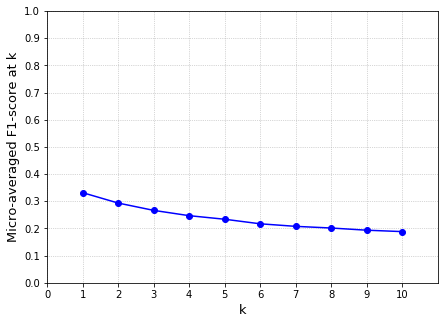

In [21]:
plt.clf()
ax = plt.gca()


# {'nn__n_neighbors': 75, 'vect__max_features': 1000, 'nn__metric': 'manhattan', 'vect__norm': 'l2'}
validation_scores = [0.33167495854063017, 0.29346904156064463,
    0.2665134979896611 , 0.2470050098017861,
    0.23384831460674158, 0.21710234824988922,
    0.2076864342071774,  0.20156424581005586,
    0.19353551476456504, 0.18836664865838285]

ax = plt.gca()
plot_micro_f1_at_k(validation_scores,ax)
plt.gca().legend_.remove()

plt.gcf().set_size_inches(7,5)
plt.show()